# Using a Tensorflow Custom Estimator to classify Titanic dataset

My focus here is just show a basic approach of a Custom Estimator using Google's Open Source TensorFlow library.

The TensorFlow team developed the Estimator API to make the library more accessible to the everyday developer. This high level API provides a common interface to train(...) models, evaluate(...) models, and predict(...) outcomes of unknown cases similar to (and influenced by) the popular Sci-Kit Learn library, which is accomplished by implementing a common interface for various algorithms. Some functions used here are copied from   

### Load data after feat. engineering and cleanning data

In [31]:
import pandas as pd
import numpy as np

I did the feature engineering and cleaning step separately. If want to see more details please, see here: [ Titanic Best Working Classfier:](https://www.kaggle.com/sinakhorami/titanic-best-working-classifier) by Sina

In [32]:
train = pd.read_csv('./data/train-ready.csv')
test = pd.read_csv('./data/test-ready.csv')

In [33]:
train.head(5)

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone,Title
0,0,3,1,1,0,0,0,1
1,1,1,0,2,3,1,0,3
2,1,3,0,1,1,0,1,2
3,1,1,0,2,3,0,0,3
4,0,3,1,2,1,0,1,1


### Custom Estimator using tensorFlow

In [34]:
import tensorflow as tf

We will create a DNN with three hidden layers, and dropout of 0.1 probability. Creating three fully connected layers each layer having a dropout probability of 0.1.

#### Create the model

Function to create the model

In [35]:
def my_model(features, labels, mode, params):
    """DNN with three hidden layers, and dropout of 0.1 probability."""
    # Create three fully connected layers each layer having a dropout
    # probability of 0.1.
    net = tf.feature_column.input_layer(features, params['feature_columns'])
    for units in params['hidden_units']:
        net = tf.layers.dense(net, units=units, activation=tf.nn.relu)

    # Compute logits (1 per class).
    logits = tf.layers.dense(net, params['n_classes'], activation=None)

    # Compute predictions.
    predicted_classes = tf.argmax(logits, 1)
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'class_ids': predicted_classes[:, tf.newaxis],
            'probabilities': tf.nn.softmax(logits),
            'logits': logits,
        }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # Compute loss.
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Compute evaluation metrics.
    accuracy = tf.metrics.accuracy(labels=labels,
                                   predictions=predicted_classes,
                                   name='acc_op')
    metrics = {'accuracy': accuracy}
    tf.summary.scalar('accuracy', accuracy[1])

    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(
            mode, loss=loss, eval_metric_ops=metrics)

    # Create training op.
    assert mode == tf.estimator.ModeKeys.TRAIN

    optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

In [36]:
def train_input_fn(features, labels, batch_size):
    """An input function for training"""

    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    dataset = dataset.shuffle(10).repeat().batch(batch_size)
    return dataset

In [37]:
def eval_input_fn(features, labels, batch_size):
    """An input function for evaluation or prediction"""
    features=dict(features)
    if labels is None:
        inputs = features
    else:
        inputs = (features, labels)

    dataset = tf.data.Dataset.from_tensor_slices(inputs)
    
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    return dataset

In [38]:
y = train.pop('Survived')
X = train

In [39]:
feature_columns = []

for key in X.keys():
    feature_columns.append(tf.feature_column.numeric_column(key=key))

Build 2 hidden layer DNN with 10, 10 units respectively

In [40]:
classifier = tf.estimator.Estimator(
    model_fn=my_model,
    params={
        'feature_columns': feature_columns,
        # Two hidden layers of 10 nodes each.
        'hidden_units': [10, 10],
        # The model must choose between 3 classes.
        'n_classes': 2,
    })

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1183e62e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


#### Train and evaluation the Model

In [41]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, median_absolute_error

In [42]:
batch_size = 100
train_steps = 400

evaluations = []  
for i in range(100):
    
    classifier.train(
        input_fn=lambda:train_input_fn(X, y,
                                       batch_size),
        steps=train_steps)
    
    eval_result = classifier.evaluate(
        input_fn=lambda:eval_input_fn(X, y,
                                      batch_size)
    )
    
    evaluations.append(eval_result)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt.
INFO:tensorflow:loss = 0.82634896, step = 1
INFO:tensorflow:global_step/sec: 486.523
INFO:tensorflow:loss = 0.53597015, step = 101 (0.206 sec)
INFO:tensorflow:global_step/sec: 652.934
INFO:tensorflow:loss = 0.43646815, step = 201 (0.153 sec)
INFO:tensorflow:global_step/sec: 665.69
INFO:tensorflow:loss = 0.45794553, step = 301 (0.150 sec)
INFO:tensorflow:Saving checkpoints for 400 into /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt.
INFO:tensorflow:Loss for final step: 0.35757026.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-20-02:15:28
IN

INFO:tensorflow:global_step/sec: 626.625
INFO:tensorflow:loss = 0.42442018, step = 2301 (0.159 sec)
INFO:tensorflow:Saving checkpoints for 2400 into /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt.
INFO:tensorflow:Loss for final step: 0.31510934.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-20-02:15:38
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt-2400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-20-02:15:38
INFO:tensorflow:Saving dict for global step 2400: accuracy = 0.8473625, global_step = 2400, loss = 0.38180995
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameter

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-20-02:15:48
INFO:tensorflow:Saving dict for global step 4400: accuracy = 0.8484849, global_step = 4400, loss = 0.37090957
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt-4400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 4401 into /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt.
INFO:tensorflow:loss = 0.4373948, step = 4401
INFO:tensorflow:global_step/sec: 496.551
INFO:tensorflow:loss = 0.48416844, step = 4501 (0.202 sec)
INFO:tensorflow:global_step/sec: 639.011
INFO:tensorflow:loss = 0.34305018, step = 4601 (0.158 sec)
INFO:tensorflow:global_s

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 6401 into /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt.
INFO:tensorflow:loss = 0.39669213, step = 6401
INFO:tensorflow:global_step/sec: 480.843
INFO:tensorflow:loss = 0.47595683, step = 6501 (0.210 sec)
INFO:tensorflow:global_step/sec: 659.695
INFO:tensorflow:loss = 0.3558664, step = 6601 (0.151 sec)
INFO:tensorflow:global_step/sec: 684.389
INFO:tensorflow:loss = 0.4048891, step = 6701 (0.146 sec)
INFO:tensorflow:Saving checkpoints for 6800 into /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt.
INFO:tensorflow:Loss for final step: 0.31071177.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-20-02:16:00
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.c

INFO:tensorflow:Saving checkpoints for 8800 into /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt.
INFO:tensorflow:Loss for final step: 0.28802064.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-20-02:16:09
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt-8800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-20-02:16:09
INFO:tensorflow:Saving dict for global step 8800: accuracy = 0.8529742, global_step = 8800, loss = 0.3589877
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt-8800
INFO:tensorflow:R

INFO:tensorflow:Finished evaluation at 2018-03-20-02:16:19
INFO:tensorflow:Saving dict for global step 10800: accuracy = 0.8518519, global_step = 10800, loss = 0.35684425
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt-10800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 10801 into /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt.
INFO:tensorflow:loss = 0.4005825, step = 10801
INFO:tensorflow:global_step/sec: 467.685
INFO:tensorflow:loss = 0.52182174, step = 10901 (0.215 sec)
INFO:tensorflow:global_step/sec: 422.483
INFO:tensorflow:loss = 0.29970777, step = 11001 (0.236 sec)
INFO:tensorflow:global_step/sec: 440.995
INFO:tensorflow:loss = 0.38490728, step = 11101 (0.227 sec)

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 12801 into /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt.
INFO:tensorflow:loss = 0.43620655, step = 12801
INFO:tensorflow:global_step/sec: 480.95
INFO:tensorflow:loss = 0.48577866, step = 12901 (0.209 sec)
INFO:tensorflow:global_step/sec: 650.495
INFO:tensorflow:loss = 0.33506286, step = 13001 (0.154 sec)
INFO:tensorflow:global_step/sec: 674.4
INFO:tensorflow:loss = 0.3781147, step = 13101 (0.148 sec)
INFO:tensorflow:Saving checkpoints for 13200 into /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt.
INFO:tensorflow:Loss for final step: 0.2733697.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-20-02:16:31
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt-13200
INFO:tensorflow:Running lo

INFO:tensorflow:Saving checkpoints for 15200 into /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt.
INFO:tensorflow:Loss for final step: 0.28427106.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-20-02:16:41
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt-15200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-20-02:16:41
INFO:tensorflow:Saving dict for global step 15200: accuracy = 0.8518519, global_step = 15200, loss = 0.35209513
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt-15200
INFO:tensor

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-20-02:16:51
INFO:tensorflow:Saving dict for global step 17200: accuracy = 0.8518519, global_step = 17200, loss = 0.35059115
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt-17200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 17201 into /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt.
INFO:tensorflow:loss = 0.4019083, step = 17201
INFO:tensorflow:global_step/sec: 482.993
INFO:tensorflow:loss = 0.4737358, step = 17301 (0.208 sec)
INFO:tensorflow:global_step/sec: 621.315
INFO:tensorflow:loss = 0.33535483, step = 17401 (0.161 sec)
INFO:tensorflow:global_step/sec: 675.201
INFO:tensorflow:

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 19201 into /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt.
INFO:tensorflow:loss = 0.39745805, step = 19201
INFO:tensorflow:global_step/sec: 472.947
INFO:tensorflow:loss = 0.48768756, step = 19301 (0.213 sec)
INFO:tensorflow:global_step/sec: 622.432
INFO:tensorflow:loss = 0.30836096, step = 19401 (0.160 sec)
INFO:tensorflow:global_step/sec: 655.145
INFO:tensorflow:loss = 0.37588912, step = 19501 (0.153 sec)
INFO:tensorflow:Saving checkpoints for 19600 into /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt.
INFO:tensorflow:Loss for final step: 0.27245402.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-20-02:17:03
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6

INFO:tensorflow:loss = 0.3819569, step = 21501 (0.153 sec)
INFO:tensorflow:Saving checkpoints for 21600 into /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt.
INFO:tensorflow:Loss for final step: 0.26855546.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-20-02:17:13
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt-21600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-20-02:17:13
INFO:tensorflow:Saving dict for global step 21600: accuracy = 0.8507295, global_step = 21600, loss = 0.34816748
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/y7/1vddc8q51zq_q_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-20-02:17:22
INFO:tensorflow:Saving dict for global step 23600: accuracy = 0.8507295, global_step = 23600, loss = 0.34730524
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt-23600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 23601 into /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt.
INFO:tensorflow:loss = 0.39546555, step = 23601
INFO:tensorflow:global_step/sec: 512.829
INFO:tensorflow:loss = 0.5157379, step = 23701 (0.196 sec)
INFO:tensorflow:global_step/sec: 665.3
INFO:tensorflow:loss = 0.28118083, step = 23801 (0.151 sec)
INFO:tensorflow:glo

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 25601 into /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt.
INFO:tensorflow:loss = 0.42017433, step = 25601
INFO:tensorflow:global_step/sec: 462.745
INFO:tensorflow:loss = 0.49049926, step = 25701 (0.217 sec)
INFO:tensorflow:global_step/sec: 626.735
INFO:tensorflow:loss = 0.32804477, step = 25801 (0.160 sec)
INFO:tensorflow:global_step/sec: 625.634
INFO:tensorflow:loss = 0.38036302, step = 25901 (0.160 sec)
INFO:tensorflow:Saving checkpoints for 26000 into /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt.
INFO:tensorflow:Loss for final step: 0.2679368.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-20-02:17:33
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/

INFO:tensorflow:loss = 0.3894179, step = 27901 (0.159 sec)
INFO:tensorflow:Saving checkpoints for 28000 into /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt.
INFO:tensorflow:Loss for final step: 0.26185092.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-20-02:17:43
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt-28000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-20-02:17:43
INFO:tensorflow:Saving dict for global step 28000: accuracy = 0.84960717, global_step = 28000, loss = 0.3460258
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/y7/1vddc8q51zq_q_

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-20-02:17:53
INFO:tensorflow:Saving dict for global step 30000: accuracy = 0.8507295, global_step = 30000, loss = 0.34479436
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt-30000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 30001 into /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt.
INFO:tensorflow:loss = 0.42063373, step = 30001
INFO:tensorflow:global_step/sec: 502.144
INFO:tensorflow:loss = 0.46520543, step = 30101 (0.200 sec)
INFO:tensorflow:global_step/sec: 628.383
INFO:tensorflow:loss = 0.3303492, step = 30201 (0.160 sec)
INFO:tensorflow:g

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 32001 into /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt.
INFO:tensorflow:loss = 0.39493725, step = 32001
INFO:tensorflow:global_step/sec: 490.489
INFO:tensorflow:loss = 0.4788207, step = 32101 (0.205 sec)
INFO:tensorflow:global_step/sec: 637.735
INFO:tensorflow:loss = 0.29124033, step = 32201 (0.157 sec)
INFO:tensorflow:global_step/sec: 647.907
INFO:tensorflow:loss = 0.38514718, step = 32301 (0.154 sec)
INFO:tensorflow:Saving checkpoints for 32400 into /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt.
INFO:tensorflow:Loss for final step: 0.26421916.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-20-02:18:04
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/

INFO:tensorflow:loss = 0.3979691, step = 34301 (0.165 sec)
INFO:tensorflow:Saving checkpoints for 34400 into /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt.
INFO:tensorflow:Loss for final step: 0.26909474.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-20-02:18:14
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt-34400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-20-02:18:14
INFO:tensorflow:Saving dict for global step 34400: accuracy = 0.8507295, global_step = 34400, loss = 0.3436789
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/y7/1vddc8q51zq_q_d

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-20-02:18:23
INFO:tensorflow:Saving dict for global step 36400: accuracy = 0.8529742, global_step = 36400, loss = 0.34338453
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt-36400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 36401 into /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt.
INFO:tensorflow:loss = 0.40057036, step = 36401
INFO:tensorflow:global_step/sec: 493.126
INFO:tensorflow:loss = 0.47994918, step = 36501 (0.204 sec)
INFO:tensorflow:global_step/sec: 677.447
INFO:tensorflow:loss = 0.3164008, step = 36601 (0.148 sec)
INFO:tensorflow:g

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 38401 into /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt.
INFO:tensorflow:loss = 0.40591243, step = 38401
INFO:tensorflow:global_step/sec: 443.441
INFO:tensorflow:loss = 0.489381, step = 38501 (0.226 sec)
INFO:tensorflow:global_step/sec: 595.781
INFO:tensorflow:loss = 0.30325878, step = 38601 (0.168 sec)
INFO:tensorflow:global_step/sec: 631.711
INFO:tensorflow:loss = 0.38508815, step = 38701 (0.158 sec)
INFO:tensorflow:Saving checkpoints for 38800 into /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt.
INFO:tensorflow:Loss for final step: 0.25573027.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-20-02:18:35
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/m

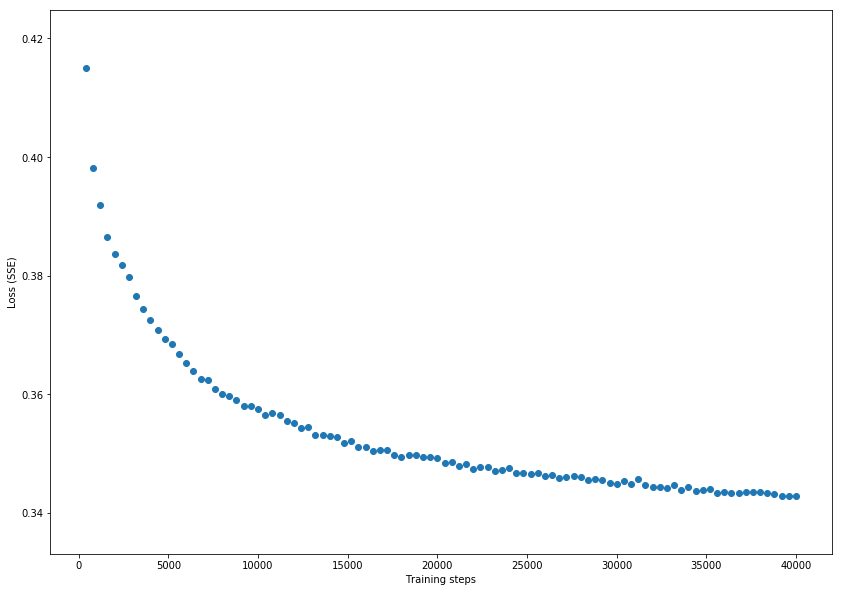

In [43]:
import matplotlib.pyplot as plt  
%matplotlib inline

# manually set the parameters of the figure to and appropriate size
plt.rcParams['figure.figsize'] = [14, 10]

loss_values = [ev['loss'] for ev in evaluations]  
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)  
plt.xlabel('Training steps')  
plt.ylabel('Loss (SSE)')  
plt.show() 

#### Generate predictions from the model

In [44]:
predictions = classifier.predict(
    input_fn=lambda:eval_input_fn(test,labels=None,
    batch_size=batch_size))

In [45]:
results = list(predictions)

def x(res,j):
    class_id = res[j]['class_ids'][0]
    probability = int(results[i]['probabilities'][class_id] *100)

    if int(class_id) == 0:
        return ('%s%% probalitity to %s' % (probability,'Not survive'))
    else:
        return ('%s%% probalitity to %s' % (probability,'Survive!'))

print ('Predictions for 10 first records on test(dataset):')

for i in range(0,10):    
    print (x(results,i))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/y7/1vddc8q51zq_q_dc0gw581480000gn/T/tmpnakab0c6/model.ckpt-40000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Predictions for 10 first records on test(dataset):
99% probalitity to Not survive
97% probalitity to Not survive
99% probalitity to Not survive
84% probalitity to Not survive
51% probalitity to Survive!
90% probalitity to Not survive
72% probalitity to Survive!
95% probalitity to Not survive
85% probalitity to Survive!
97% probalitity to Not survive


#### Generate the csv to submit. 

In [46]:
len(results)

418

In [47]:
train.tail(1)

,Pclass,Sex,Age,Fare,Embarked,IsAlone,Title
890,3,1,1,0,2,1,1


In [48]:
passengers = {}
i = 892
for x in results:
    passengers[i] = int(x['class_ids'][0])
    i+=1

In [49]:
import csv
csvfile = './submissions.csv'
with open(csvfile, 'w') as f:
    outcsv = csv.writer(f, delimiter=',')
    header = ['PassengerId','Survived']
    outcsv.writerow(header)
    for k,v in passengers.items():
        outcsv.writerow([k,v])

In [51]:
submissions = pd.read_csv(csvfile)
submissions.head(5)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
